<a href="https://colab.research.google.com/github/Himanshu-1703/reddit-sentiment-analysis/blob/main/Reddit_Data_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load the Packages

In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
import missingno
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import plotly.express as px
from collections import Counter
from nltk.tokenize import word_tokenize

In [ ]:
nltk.download("all")

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_r

True

# Load Data

In [ ]:
# load the data

DATA_PATH = r"https://raw.githubusercontent.com/Himanshu-1703/reddit-sentiment-analysis/refs/heads/main/data/reddit.csv"

df = pd.read_csv(DATA_PATH)

df

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1
...,...,...
37244,jesus,0
37245,kya bhai pure saal chutiya banaya modi aur jab...,1
37246,downvote karna tha par upvote hogaya,0
37247,haha nice,1


In [ ]:
# rename columns

df.rename({"clean_comment":"comment",
           "category":"sentiment"},axis=1,inplace=True)

In [ ]:
# missing data

df.isna().sum()

,0
comment,100
sentiment,0


**There are 100 missing values in the comment**

<Axes: >

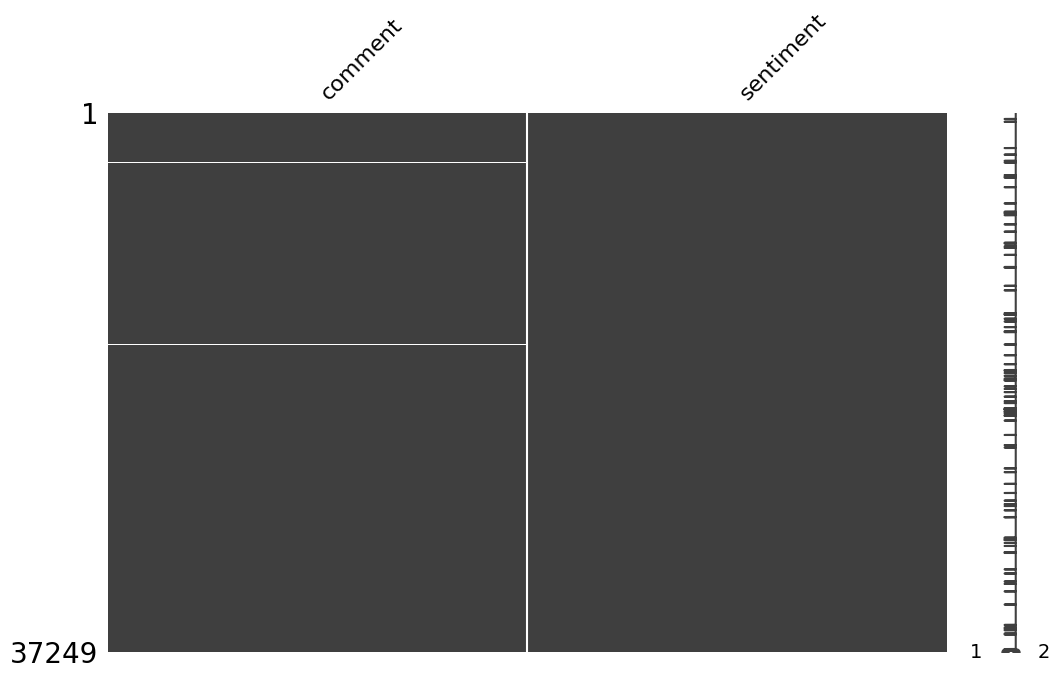

In [ ]:
# missing values matrix

missingno.matrix(df,figsize=(12,7))

In [ ]:
# rows that have missing values

(
    df.loc[
        df['comment'].isna()
    ]
)

,comment,sentiment
413,NaN,0
605,NaN,0
2422,NaN,0
2877,NaN,0
3307,NaN,0
...,...,...
35975,NaN,0
36036,NaN,0
37043,NaN,0
37111,NaN,0


In [ ]:
# sentiment of rows that have missing values

(
    df.loc[
        df['comment'].isna(),"sentiment"
    ]
    .value_counts()
)

,count
sentiment,
0,100


**All rows that have missing values have been labelled the sentiment of 0 (neutral)**

In [ ]:
# check for duplicate comments in the data

print(df['comment'].dropna().duplicated().sum())

350


**`350` comments in the data are duplicated**

In [ ]:
# shape of the data

data_rows, data_cols = df.shape
print(f'The data has {data_rows} rows and {data_cols} columns')

The data has 37249 rows and 2 columns


In [ ]:
# comments having words like modi,bjp and congress

(
    df
    .dropna()
    .loc[(lambda df_: df_['comment'].str.contains(r"bjp|congress|modi")),"comment"]
)

,comment
51,tea partier expresses support for namo after ...
68,can congress eliminate namo and blame advani
69,don know but surely there his statue every bj...
70,after seeing this uvjx3kwoehw video seems anyt...
72,congress needs bogeyman modi without the bad g...
...,...
37210,modi april fool
37228,also modiji will give award ravish kumar tonight
37236,fan modi but some the best people ever met li...
37245,kya bhai pure saal chutiya banaya modi aur jab...


In [ ]:
# distribution of such comments

print(
      df['comment']
      .dropna()
      .str.contains(r"bjp|congress|modi")
      .mean() * 100
    )

18.991089935126112


# Data Cleaning

In [ ]:
len(df.loc[14037,'comment'].split())

2

In [ ]:
# check for rows that have empty rows, only whitespace and new line characters

whitespace_chars = [" ","\n"]

df.loc[df['comment'].isin(whitespace_chars),"comment"]

,comment
181,
375,
392,
651,
1222,
...,...
35711,
35778,
35987,
36707,


In [ ]:
def remove_whitespaces(ser):
    return ser.str.lstrip().str.rstrip()

def remove_whitespace_chars(ser):
    chars_list = [" ","\n"]
    return ser[ser.isin(chars_list)]

def count_words(text):
    return len(text.split(" "))

def removing_numbers(text):
    text=''.join([i for i in text if not i.isdigit()])
    return text

def removing_punctuations(text):
    ## Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\\]^_`{|}~"""), ' ', text)
    text = text.replace('؛',"", )
    return text

def removing_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def clean_text(text):
    text = removing_numbers(text)
    text = removing_punctuations(text)
    text = removing_urls(text)
    return text

def sentence_length(ser):
    bins = [0,10, 25, 50, ser.max()]
    labels = ['Short', 'Medium', 'Long', 'Very Long']
    return pd.cut(ser,bins=bins,labels=labels)

def is_response(ser):
    return np.where(ser <= 3, 1, 0)

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    return " ".join(filtered_sentence)

def lemmatize(text):
    lemma = WordNetLemmatizer()
    text = [lemma.lemmatize(word) for word in text.split(" ")]
    return " ".join(text)


In [ ]:
def remove_emoji(text):
    # Regex pattern to match all emoji characters
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # Emoticons
        u"\U0001F300-\U0001F5FF"  # Symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # Transport & map symbols
        u"\U0001F700-\U0001F77F"  # Alchemical symbols
        u"\U0001F780-\U0001F7FF"  # Geometric shapes extended
        u"\U0001F800-\U0001F8FF"  # Supplemental arrows-C
        u"\U0001F900-\U0001F9FF"  # Supplemental symbols and pictographs
        u"\U0001FA00-\U0001FA6F"  # Chess symbols
        u"\U0001FA70-\U0001FAFF"  # Symbols and pictographs extended-A
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_non_ascii(text):
    # Remove all non-ASCII characters
    return re.sub(r'[^\x00-\x7F]+', '', text)

def remove_chinese(text):
    # Regex to remove Chinese characters (CJK Unified Ideographs)
    return re.sub(r'[\u4e00-\u9fff]+', '', text)

def clean_unicode_text(text):
    # Apply all cleaning functions
    text = remove_emoji(text)
    text = remove_chinese(text)
    text = remove_non_ascii(text)
    return text

In [ ]:
df['comment'].dropna().apply(count_words)

,comment
0,41
1,197
2,87
3,30
4,113
...,...
37244,1
37245,19
37246,8
37247,3


In [ ]:
def count_stop_words(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    stop_words_only = [word for word in word_tokens if word.lower() in stop_words]
    return len(stop_words_only)

def count_negative_stop_words(text):
    negative_stop_words = ["but","however","not","neither","no","nothing"]
    word_tokens = word_tokenize(text)
    neg_stop_words = [word for word in word_tokens if word.lower() in negative_stop_words]
    return len(neg_stop_words)

In [ ]:
df['comment'].dropna().sample(25).apply(count_stop_words)

,comment
8719,25
6236,17
1741,4
17211,8
4685,38
18831,8
17728,3
23448,0
20152,7
9994,0


In [ ]:
def count_pos_tags(text):
    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)

    # Define POS categories
    nouns = ['NN', 'NNS', 'NNP', 'NNPS']
    verbs = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
    adjectives = ['JJ', 'JJR', 'JJS']

    # Count the POS tags
    pos_counts = Counter(tag for word, tag in pos_tags)

    num_nouns = sum(pos_counts[pos] for pos in nouns)
    num_verbs = sum(pos_counts[pos] for pos in verbs)
    num_adjectives = sum(pos_counts[pos] for pos in adjectives)
    return pd.Series({'nouns': num_nouns, 'verbs': num_verbs, 'adjectives': num_adjectives})

In [ ]:
def clean_data(data):

    return (
        data
        .dropna()
        .drop_duplicates(subset=['comment'])
        .loc[lambda df_: ~df_['comment'].isin([" ","\n"])]
        .assign(
            stop_words_count = lambda df_: df_.loc[:,'comment'].apply(count_stop_words),
            neg_stop_words_count = lambda df_: df_.loc[:,'comment'].apply(count_negative_stop_words)
        )
        .assign(
            comment = lambda df_: df_.loc[:,"comment"].apply(clean_text)
        )
        .assign(
            comment = lambda df_: df_.loc[:,"comment"].str.lstrip().str.rstrip().str.lower(),
            word_count = lambda df_: df_.loc[:,"comment"].apply(count_words),
            named_sentiment = lambda df_: df_.loc[:,"sentiment"].replace({0:"neutral",
                                                                         -1:"negative",
                                                                          1:"positive"}),
            sentence_length = lambda df_: df_.loc[:,"word_count"].pipe(sentence_length),
            response = lambda df_: df_.loc[:,"word_count"].pipe(is_response)
        )
        .assign(
            comment = lambda df_: df_.loc[:,"comment"].apply(removing_punctuations)
        )
        .assign(
            comment = lambda df_: df_.loc[:,"comment"].apply(clean_unicode_text)
        )
        .assign(
            comment = lambda df_: df_.loc[:,"comment"].apply(remove_stopwords)
        )
        .assign(
            comment = lambda df_: df_.loc[:,"comment"].apply(lemmatize)
        )
        .loc[lambda df_: ~(df_['comment'].str.contains(r"bjp|congress|modi")),:]
    )

In [ ]:
final_df = clean_data(df)

In [ ]:
final_df.sample(30)

,comment,sentiment,stop_words_count,neg_stop_words_count,word_count,named_sentiment,sentence_length,response
12019,dangal good think result good think result goo...,1,52,8,76,positive,Very Long,0
12600,still trace competition party might win even b...,1,5,0,14,positive,Medium,0
13077,need help else loose belgium might take someon...,-1,9,0,23,negative,Medium,0
21567,jrmungandr,0,0,0,1,neutral,Short,1
6695,simply decided worth continuing previous cast ...,1,31,2,87,positive,Very Long,0
7506,wtf,-1,0,0,1,negative,Short,1
13415,intolerance one particular religion,1,2,0,6,positive,Short,0
30903,death journalism look like state sponsored ad ...,0,5,0,19,neutral,Medium,0
5075,agree point child born matter india matter pro...,1,88,8,246,positive,Very Long,0
19073,came,0,0,0,1,neutral,Short,1


In [ ]:
# form the pos tag count data

pos_tag_data = final_df['comment'].apply(count_pos_tags)

In [ ]:
pos_tag_data

,nouns,verbs,adjectives
0,16,4,2
1,58,30,24
2,18,7,10
3,7,4,2
4,20,19,12
...,...,...,...
37242,8,0,0
37243,7,5,2
37244,1,0,0
37246,4,0,1


In [ ]:
final_df = final_df.join(pos_tag_data)

In [ ]:
# check cleaned df for missing values

final_df.isna().sum()

,0
comment,0
sentiment,0
stop_words_count,0
neg_stop_words_count,0
word_count,0
named_sentiment,0
sentence_length,0
response,0
nouns,0
verbs,0


In [ ]:
# shape of cleaned data

final_df.shape

(29751, 11)

In [ ]:
# save the cleaned data as csv

final_df.to_csv("cleaned_data.csv",index=False)

# EDA

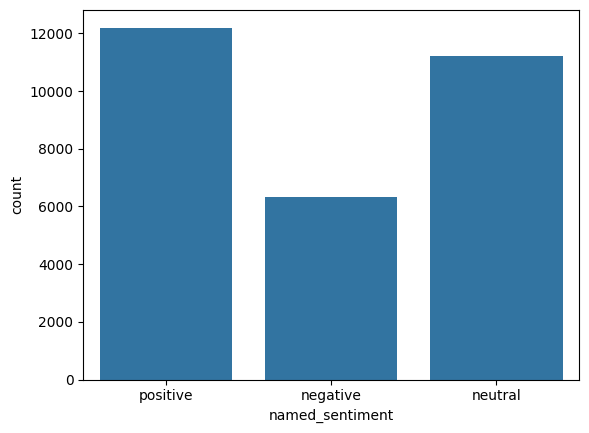

In [ ]:
# distribution of classes

sns.countplot(data=final_df,x="named_sentiment");

**Clearly the data shows class imbalance**

In [ ]:
# frequency distribution of sentiments

final_df['named_sentiment'].value_counts(normalize=True).mul(100).round(2)

,proportion
named_sentiment,
positive,41.01
neutral,37.68
negative,21.31


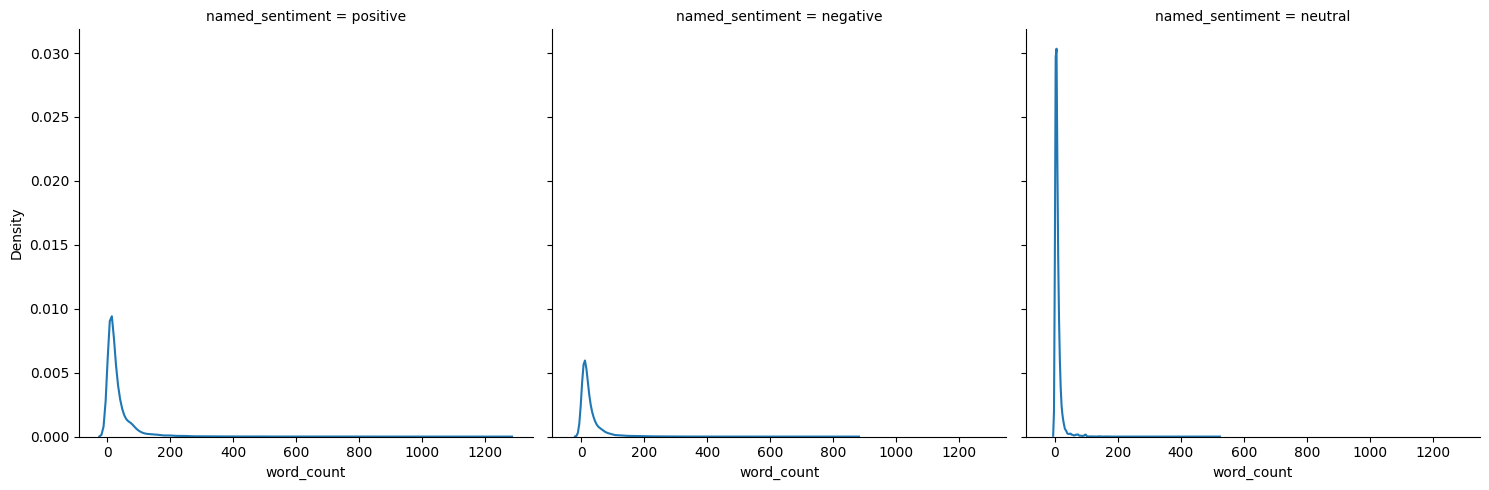

In [ ]:
# distribution of word_count per sentiment

sns.displot(final_df,x='word_count',col='named_sentiment',kind='kde');

<Axes: xlabel='word_count', ylabel='Density'>

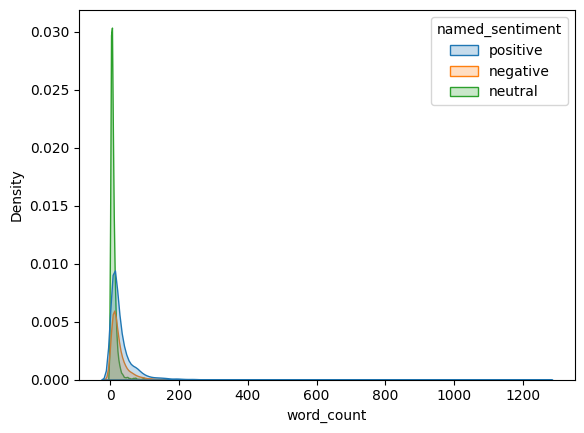

In [ ]:
# distribution of word_count per sentiment

sns.kdeplot(final_df,x='word_count',hue='named_sentiment',fill=True)

In [ ]:
# statistical summary of word_count

sentiment_grp = final_df.groupby("named_sentiment")

sentiment_grp['word_count'].agg(["min","max","median","mean"])

,min,max,median,mean
named_sentiment,,,,
negative,1,862,17.0,28.119577
neutral,1,518,6.0,9.372435
positive,1,1258,18.0,34.547369


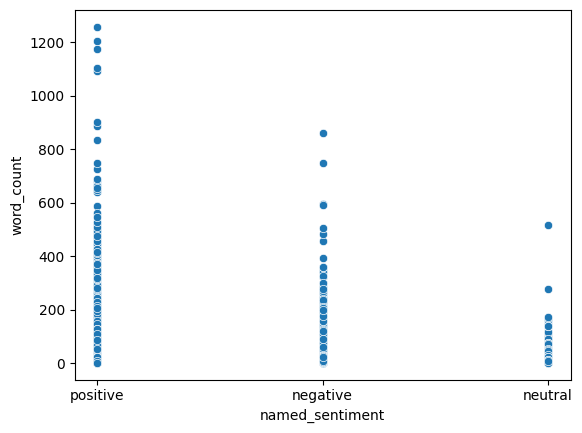

In [ ]:
#sentiment vs word_count

sns.scatterplot(final_df,x='named_sentiment',y='word_count');

In [ ]:
# sentiment vs word count --> boxplots

px.box(data_frame=final_df,x='named_sentiment',y='word_count')

In [ ]:
# distribution of sentence length based on sentiment

pd.crosstab(index=final_df['named_sentiment'],columns=final_df['sentence_length'],normalize=True).mul(100)

sentence_length,Short,Medium,Long,Very Long
named_sentiment,,,,
negative,6.440120,7.835031,4.144399,2.887298
neutral,27.720077,8.117374,1.230211,0.611744
positive,12.480253,13.249975,7.912339,7.371181


In [ ]:
import warnings

warnings.filterwarnings("ignore")
fig = px.sunburst(final_df,path=['named_sentiment','sentence_length'],width=700,height=700)
fig.show()

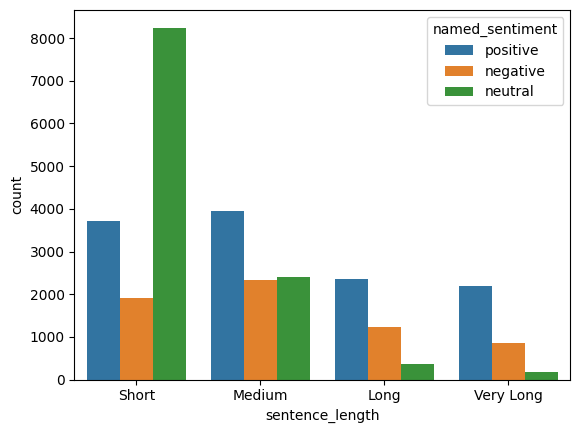

In [ ]:
# sentence length distribution among sentences

sns.countplot(final_df,x='sentence_length',hue='named_sentiment');

<Axes: xlabel='stop_words_count', ylabel='Density'>

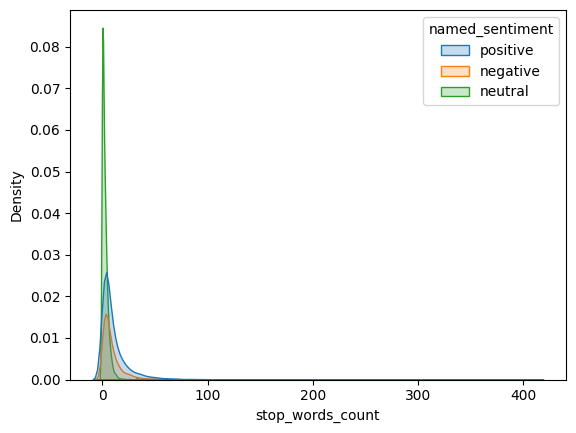

In [ ]:
# kdeplot of stopwords count

sns.kdeplot(final_df,x='stop_words_count',hue='named_sentiment',fill=True)

<Axes: xlabel='neg_stop_words_count', ylabel='Density'>

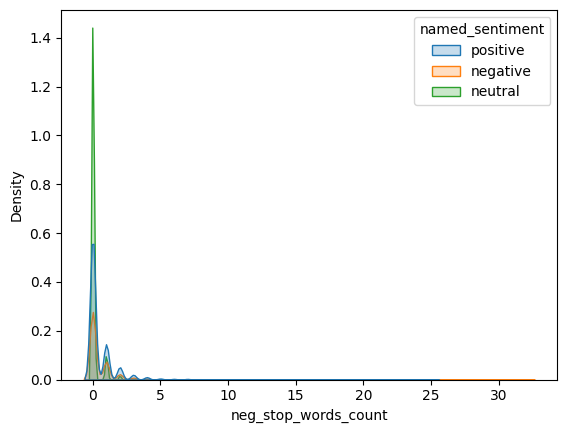

In [ ]:
# kdeplot of  negative stopwords count

sns.kdeplot(final_df,x='neg_stop_words_count',hue='named_sentiment',fill=True)

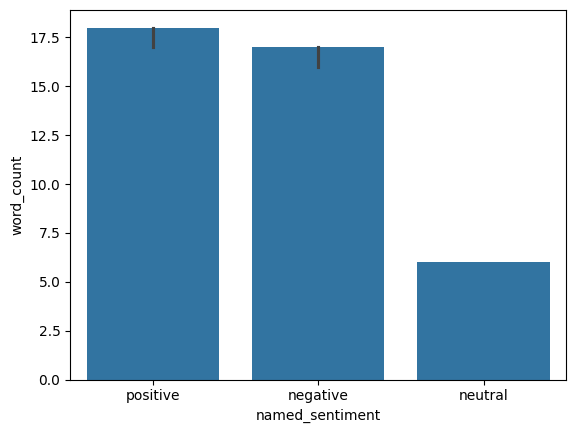

In [ ]:
# median word counts among sentiments

sns.barplot(final_df,x='named_sentiment',y='word_count',estimator='median');

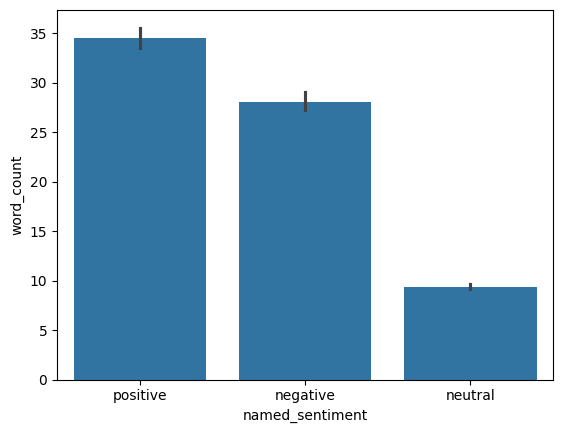

In [ ]:
# avg word counts among sentiments

sns.barplot(final_df,x='named_sentiment',y='word_count',estimator='mean');

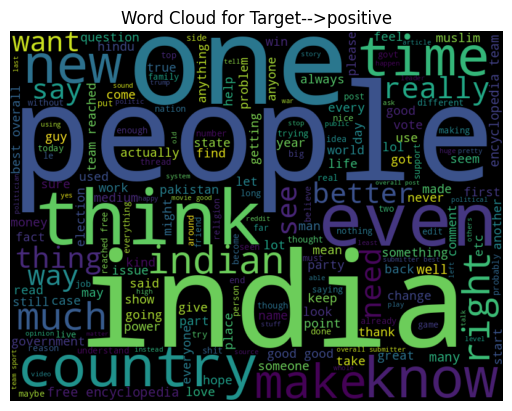

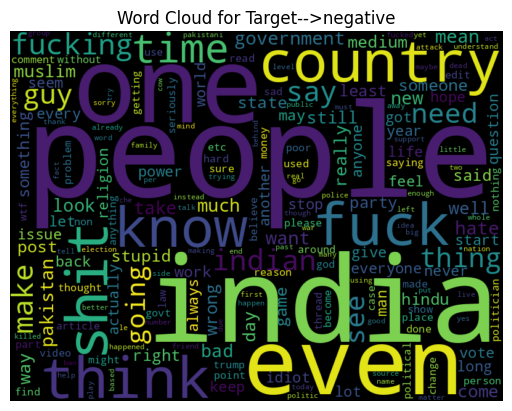

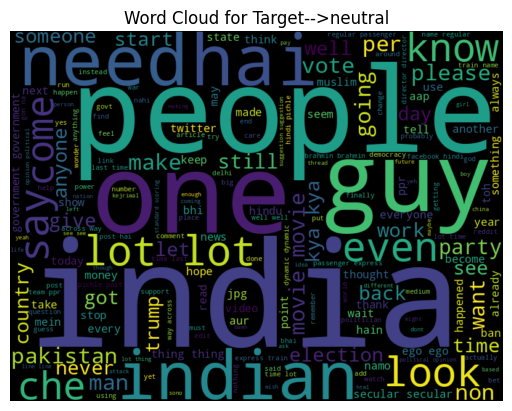

In [ ]:
# plot wordclouds for each sentiment

def plot_wordcloud(target_class):
    text = ' '.join(final_df.loc[(final_df['named_sentiment'] == target_class),"comment"])
    wordcloud = WordCloud(width=800, height=600).generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Target-->{target_class}')
    plt.show()

for sentiment in final_df['named_sentiment'].unique().tolist():
    plot_wordcloud(sentiment)

In [ ]:
# top 15 words and their count in each sentiment

def tokenize_sentences(text):
    tokens = nltk.word_tokenize(text)
    return tokens

tokens = final_df.loc[:,"comment"].apply(tokenize_sentences)

positive_tokens = tokens.loc[final_df['named_sentiment'] == "positive"].sum()
neutral_tokens = tokens.loc[final_df['named_sentiment'] == "neutral"].sum()
negative_tokens = tokens.loc[final_df['named_sentiment'] == "negative"].sum()

In [ ]:
# find the top 15 words

def get_top_words(tokens, n=10):
    word_counts = Counter(tokens)
    return word_counts.most_common(n)

top_15_positive = get_top_words(positive_tokens,15)
top_15_neutral = get_top_words(neutral_tokens,15)
top_15_negative = get_top_words(negative_tokens,15)

print("Top 10 words for Positive sentiment:", top_15_positive)
print("Top 10 words for Neutral sentiment:", top_15_neutral)
print("Top 10 words for Negative sentiment:", top_15_negative)

Top 10 words for Positive sentiment: [('good', 2358), ('people', 2222), ('like', 2080), ('india', 1894), ('one', 1665), ('would', 1399), ('get', 1336), ('time', 1173), ('even', 1123), ('think', 1073), ('right', 1056), ('thing', 1003), ('make', 985), ('indian', 985), ('know', 943)]
Top 10 words for Neutral sentiment: [('like', 540), ('india', 497), ('hai', 458), ('lot', 434), ('one', 391), ('time', 351), ('people', 313), ('get', 284), ('think', 261), ('thing', 245), ('che', 222), ('guy', 219), ('indian', 216), ('post', 208), ('kya', 205)]
Top 10 words for Negative sentiment: [('people', 1010), ('like', 894), ('india', 838), ('one', 719), ('get', 567), ('indian', 510), ('shit', 501), ('fuck', 493), ('thing', 488), ('even', 482), ('time', 482), ('would', 449), ('country', 421), ('know', 406), ('think', 399)]


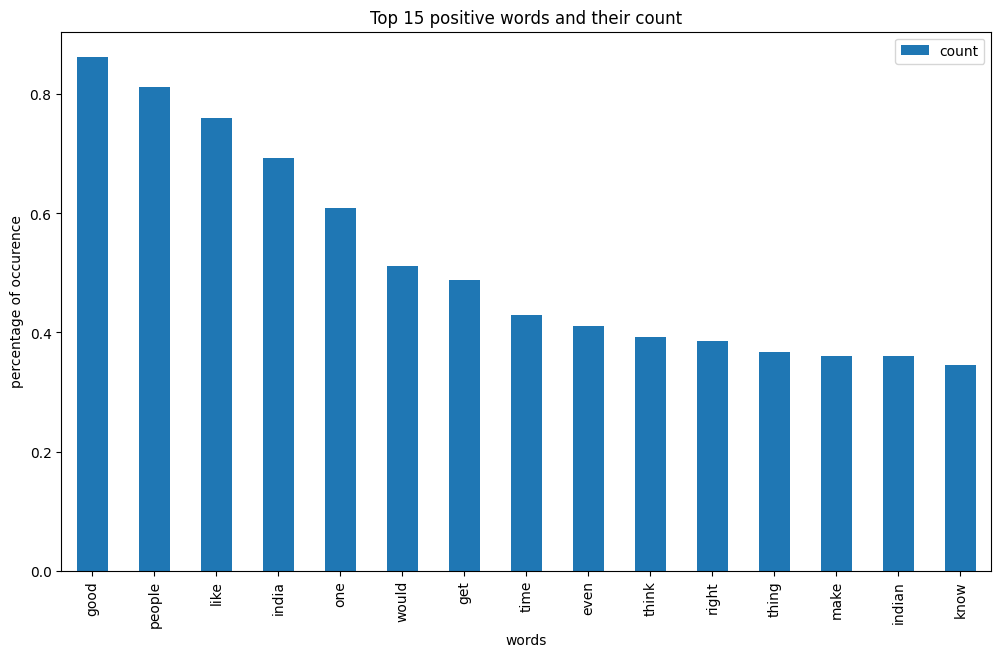

In [ ]:
# bar plot for top 15 positive sentiment words
(
    pd.DataFrame(top_15_positive,columns=['word','count'])
    .set_index('word')
    .div(len(positive_tokens))
    .mul(100)
    .plot(kind='bar',figsize=(12,7))
)
plt.xlabel("words")
plt.ylabel("percentage of occurence")
plt.title("Top 15 positive words and their count")
plt.show()

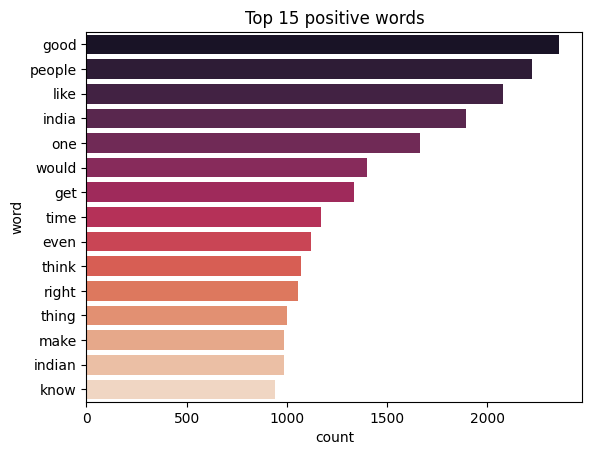

In [ ]:
# plot the top 15 positive words

sns.barplot(data=pd.DataFrame(top_15_positive,columns=['word','count']),
            x='count',y='word',palette='rocket')
plt.title("Top 15 positive words")
plt.show()

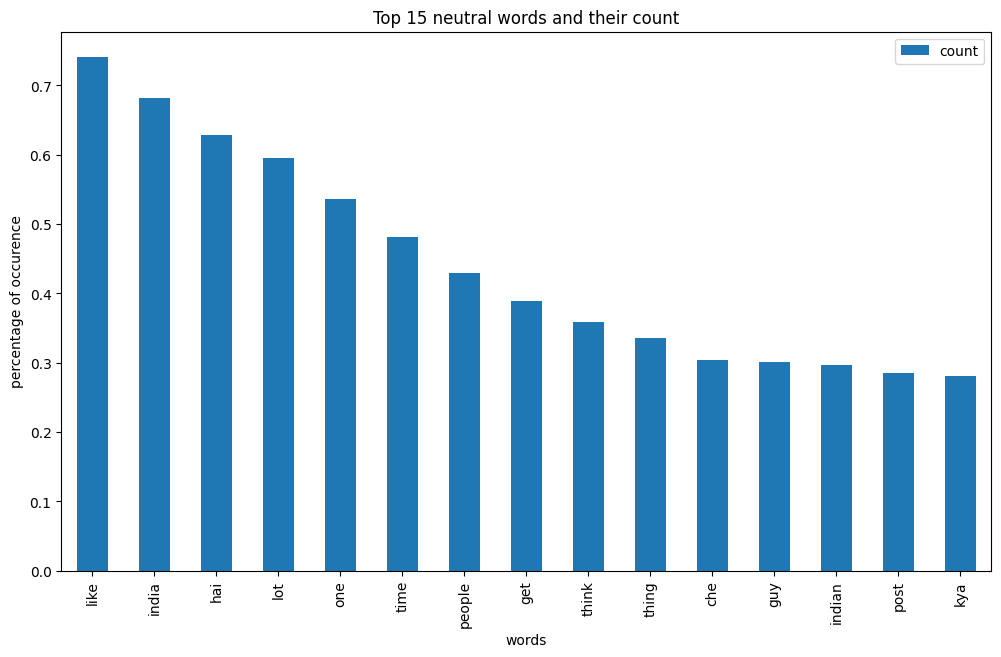

In [ ]:
# bar plot for top 15 neutral sentiment words
(
    pd.DataFrame(top_15_neutral,columns=['word','count'])
    .set_index('word')
    .div(len(neutral_tokens))
    .mul(100)
    .plot(kind='bar',figsize=(12,7))
)
plt.xlabel("words")
plt.ylabel("percentage of occurence")
plt.title("Top 15 neutral words and their count")
plt.show()

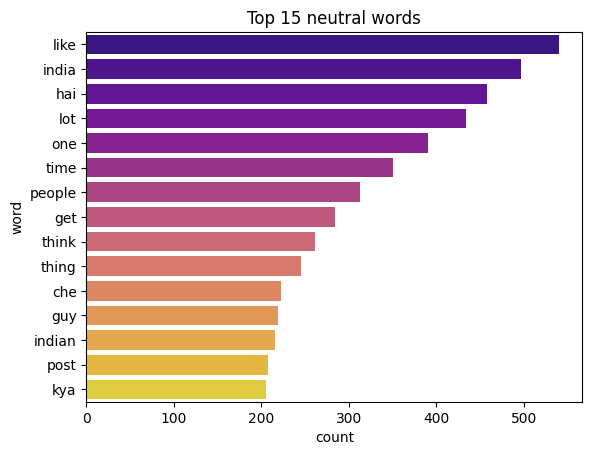

In [ ]:
# plot the top 15 neutral words

sns.barplot(data=pd.DataFrame(top_15_neutral,columns=['word','count']),
            x='count',y='word',palette='plasma')
plt.title("Top 15 neutral words")
plt.show()

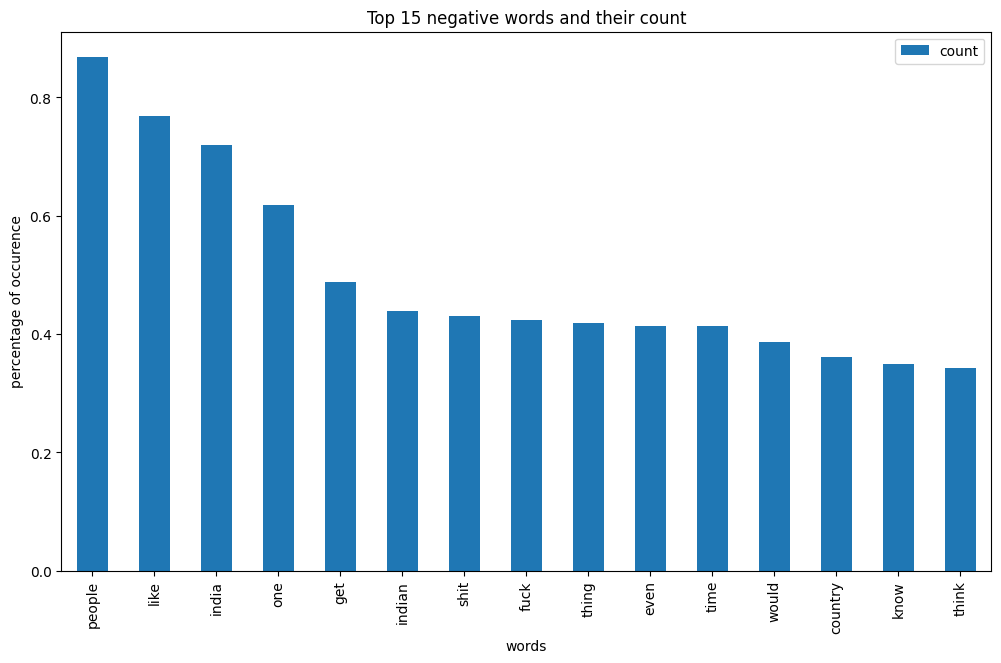

In [ ]:
# bar plot for top 15 negative sentiment words
(
    pd.DataFrame(top_15_negative,columns=['word','count'])
    .set_index('word')
    .div(len(negative_tokens))
    .mul(100)
    .plot(kind='bar',figsize=(12,7))
)
plt.xlabel("words")
plt.ylabel("percentage of occurence")
plt.title("Top 15 negative words and their count")
plt.show()

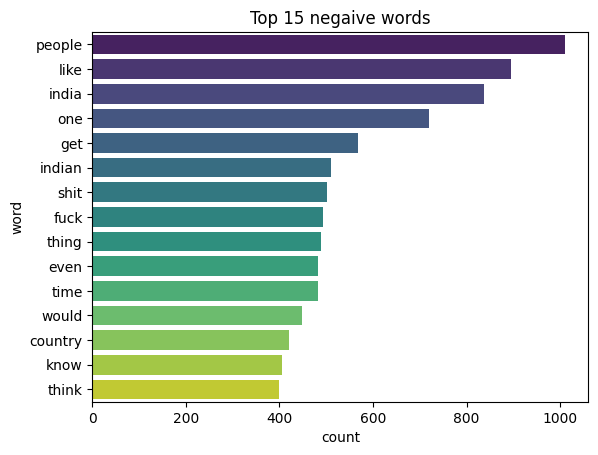

In [ ]:
# plot the top 15 negative words

sns.barplot(data=pd.DataFrame(top_15_negative,columns=['word','count']),
            x='count',y='word',palette='viridis')
plt.title("Top 15 negaive words")
plt.show()

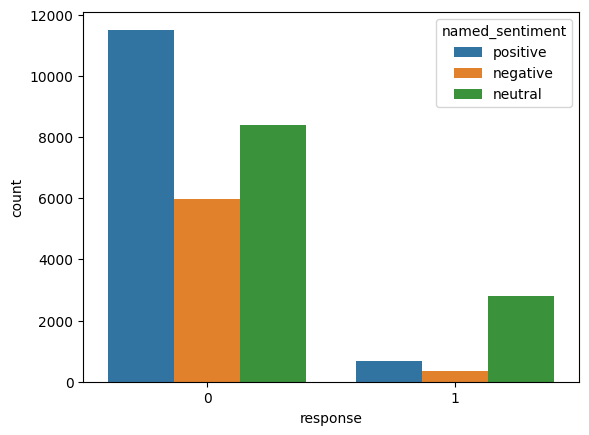

In [ ]:
# distribution of responses among sentiments
sns.countplot(final_df,x='response',hue='named_sentiment');

**Response** --> This column denotes those comments which are a length of 3 or less words, which cannot be considered a comment but are feedbacks or responses

In [ ]:
# response comments

(
    final_df
    .loc[(final_df['response'] == 1),"comment"]
)

,comment
18,zarus
46,nam indeed
47,jbdbxpxga
71,law headline
92,dry state
...,...
37230,nice try
37235,
37239,pmd
37244,jesus


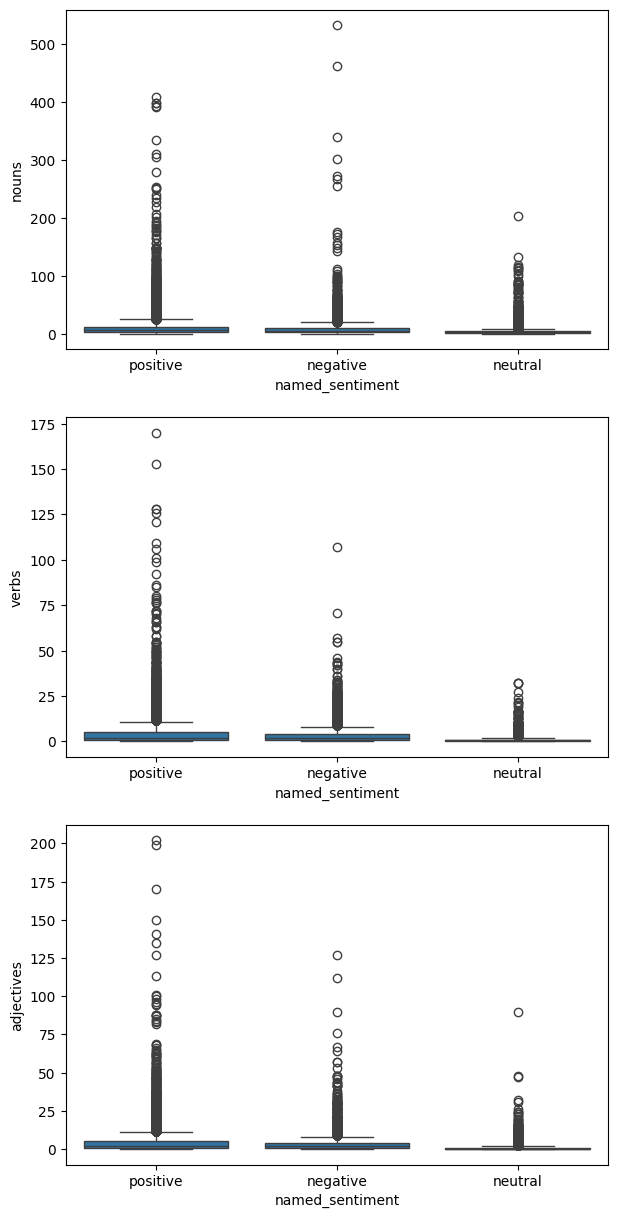

In [ ]:
# boxplots for pos tags for each sentiment

fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(7,15))

for ind,y in enumerate(final_df.columns[-3:].to_list()):
    sns.boxplot(data=final_df,x='named_sentiment',y=y,ax=ax[ind])

In [ ]:
from math import floor

In [ ]:
# statistical summary

sentiment_grp[['nouns','adjectives','verbs']].agg(["median","mean"]).map(floor)

nouns      adjectives       verbs     
                median mean     median mean median mean
named_sentiment                                        
negative             5    9          2    3      2    3
neutral              3    4          0    0      1    0
positive             6   10          2    4      2    4

# Model Pipeline

In [ ]:
final_df.head()

,comment,sentiment,stop_words_count,neg_stop_words_count,word_count,named_sentiment,sentence_length,response,nouns,verbs,adjectives
0,family mormon never tried explain still stare ...,1,13,0,39,positive,Long,0,16,4,2
1,buddhism much lot compatible christianity espe...,1,59,3,196,positive,Very Long,0,58,30,24
2,seriously say thing first get complex explain ...,-1,40,0,86,negative,Very Long,0,18,7,10
3,learned want teach different focus goal wrappi...,0,15,1,29,neutral,Long,0,7,4,2
4,benefit may want read living buddha living chr...,1,45,1,112,positive,Very Long,0,20,19,12


In [ ]:
!pip install feature-engine

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.1/364.1 kB 4.8 MB/s eta 0:00:00


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, RobustScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from feature_engine.encoding import CountFrequencyEncoder

## Feature Engineering

### Comments

In [ ]:
count_vec = CountVectorizer(decode_error='ignore',
                            stop_words='english',
                            min_df=3)
count_vec.fit_transform(final_df['comment'].sample(30)).toarray()

array([[ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  1],
       [ 1,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 1,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0, 11],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  1],
       [ 0,  0],
       [ 0,  0],
       [ 1,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  3],
       [ 0,  0],
       [ 0,  0],
       [ 0,  1],
       [ 1,  0]])

### Scaling

In [ ]:
# scaling columns

cols_to_scale = ['word_count','stop_words_count','nouns','adjectives','verbs',"neg_stop_words_count"]

scaler = RobustScaler()

scaler.set_output(transform='pandas')

scaler.fit_transform(final_df[cols_to_scale])

,word_count,stop_words_count,nouns,adjectives,verbs,neg_stop_words_count
0,1.473684,1.285714,2.000000,0.333333,1.000000,0.0
1,9.736842,7.857143,9.000000,7.666667,9.666667,3.0
2,3.947368,5.142857,2.333333,3.000000,2.000000,0.0
3,0.947368,1.571429,0.500000,0.333333,1.000000,1.0
4,5.315789,5.857143,2.666667,3.666667,6.000000,1.0
...,...,...,...,...,...,...
37242,0.000000,-0.142857,0.666667,-0.333333,-0.333333,0.0
37243,0.578947,0.285714,0.500000,0.333333,1.333333,0.0
37244,-0.526316,-0.571429,-0.500000,-0.333333,-0.333333,0.0
37246,-0.263158,-0.571429,0.000000,0.000000,-0.333333,0.0


### Encoding

In [ ]:
# categories in sentence length

final_df['sentence_length'].unique()

['Long', 'Very Long', 'Medium', 'Short']
Categories (4, object): ['Short' < 'Medium' < 'Long' < 'Very Long']

In [ ]:
ord_encoder = OrdinalEncoder(categories=[['Short','Medium','Long','Very Long']])
ord_encoder.set_output(transform='pandas')
ord_encoder.fit_transform(final_df[['sentence_length']])

ord_encoder.categories_

[array(['Short', 'Medium', 'Long', 'Very Long'], dtype=object)]

In [ ]:
# count encoding

count_enc = CountFrequencyEncoder(encoding_method='frequency')
count_enc.set_output(transform='pandas')
count_enc.fit_transform(final_df[['sentence_length']])

,sentence_length
0,0.132869
1,0.108702
2,0.108702
3,0.132869
4,0.108702
...,...
37242,0.292024
37243,0.292024
37244,0.466404
37246,0.466404


In [ ]:
sentence_union = FeatureUnion([
    ('count_enc',count_enc),
    ('ord_encoder',ord_encoder)
])

sentence_union.set_output(transform='pandas')

sentence_union.fit_transform(final_df[['sentence_length']])

,count_enc__sentence_length,ord_encoder__sentence_length
0,0.132869,2.0
1,0.108702,3.0
2,0.108702,3.0
3,0.132869,2.0
4,0.108702,3.0
...,...,...
37242,0.292024,1.0
37243,0.292024,1.0
37244,0.466404,0.0
37246,0.466404,0.0


In [ ]:
# pipeline of sentence length column

sentence_pipe = Pipeline([
    ('sentence_union',sentence_union),
    ('scale',MinMaxScaler())
])

sentence_pipe.set_output(transform='pandas')

sentence_pipe.fit_transform(final_df[['sentence_length']])

,count_enc__sentence_length,ord_encoder__sentence_length
0,0.067562,0.666667
1,0.000000,1.000000
2,0.000000,1.000000
3,0.067562,0.666667
4,0.000000,1.000000
...,...,...
37242,0.512498,0.333333
37243,0.512498,0.333333
37244,1.000000,0.000000
37246,1.000000,0.000000


In [ ]:
# make X and y

X = final_df.drop(columns=['sentiment','named_sentiment'])
y = final_df['named_sentiment']

In [ ]:
X

,comment,stop_words_count,neg_stop_words_count,word_count,sentence_length,response,nouns,verbs,adjectives
0,family mormon never tried explain still stare ...,13,0,39,Long,0,16,4,2
1,buddhism much lot compatible christianity espe...,59,3,196,Very Long,0,58,30,24
2,seriously say thing first get complex explain ...,40,0,86,Very Long,0,18,7,10
3,learned want teach different focus goal wrappi...,15,1,29,Long,0,7,4,2
4,benefit may want read living buddha living chr...,45,1,112,Very Long,0,20,19,12
...,...,...,...,...,...,...,...,...,...
37242,hona hai vaccination education insurance end m...,3,0,11,Medium,0,8,0,0
37243,agree push make nation either pity pakistan in...,6,0,22,Medium,0,7,5,2
37244,jesus,0,0,1,Short,1,1,0,0
37246,downvote karna tha par upvote hogaya,0,0,6,Short,0,4,0,1


In [ ]:
y

,named_sentiment
0,positive
1,positive
2,negative
3,neutral
4,positive
...,...
37242,neutral
37243,negative
37244,neutral
37246,neutral


In [ ]:
# train test split with test size 0.2

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,
                                                    random_state=42,stratify=y)

X_train

,comment,stop_words_count,neg_stop_words_count,word_count,sentence_length,response,nouns,verbs,adjectives
23054,gajab fakir hai hamare kaka,0,0,5,Short,0,5,0,0
33846,never gon na happen felix giving number always...,7,0,17,Medium,0,4,3,1
22590,people need elaborate mean democracy people re...,17,2,40,Long,0,12,2,7
223,harsh send keeper friendly,3,0,7,Short,0,1,1,1
16425,pas ipcc,1,0,3,Short,1,2,0,0
...,...,...,...,...,...,...,...,...,...
5033,another thing understand whenever celebrity tw...,22,1,60,Very Long,0,16,8,4
31749,literally post another sub telling worried ind...,12,0,30,Long,0,8,2,6
31306,year old person remember many thing messed nat...,23,0,69,Very Long,0,17,9,11
27772,fellow english speaker found amitabha easy eno...,32,0,74,Very Long,0,16,8,13


In [ ]:
# shapes of X_train and X_test

print(f'The shape of X_train is {X_train.shape}')
print(f'The shape of X_test is {X_test.shape}')

The shape of X_train is (23800, 9)
The shape of X_test is (5951, 9)


In [ ]:
# class distributions of y_train and y_test

print(y_train.value_counts(normalize=True))
print("*" * 30)
print(y_test.value_counts(normalize=True))

named_sentiment
positive    0.410126
neutral     0.376807
negative    0.213067
Name: proportion, dtype: float64
******************************
named_sentiment
positive    0.410183
neutral     0.376743
negative    0.213073
Name: proportion, dtype: float64


In [ ]:
# label encode y_train and y_test

le = LabelEncoder()

le.fit(y_train)

y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [ ]:
le.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

In [ ]:
# preprocessor

preprocessor = ColumnTransformer([
    ('count_vec',count_vec,'comment'),
    ('scale',scaler,cols_to_scale),
    ('sentence_pipe',sentence_pipe,['sentence_length'])
],remainder='drop',n_jobs=-1)

preprocessor

ColumnTransformer(n_jobs=-1,
                  transformers=[('count_vec',
                                 CountVectorizer(decode_error='ignore',
                                                 min_df=3,
                                                 stop_words='english'),
                                 'comment'),
                                ('scale', RobustScaler(),
                                 ['word_count', 'stop_words_count', 'nouns',
                                  'adjectives', 'verbs',
                                  'neg_stop_words_count']),
                                ('sentence_pipe',
                                 Pipeline(steps=[('sentence_union',
                                                  FeatureUnion(transformer_list=[('count_enc',
                                                                                  CountFrequencyEncoder(encoding_method='frequency')),
                                                                                 ('ord_encoder',
                                                                                  OrdinalEncoder(categories=[['Short',
                                                                                                              'Medium',
                                                                                                              'Long',
                                                                                                              'Very '
                                                                                                              'Long']]))])),
                                                 ('scale', MinMaxScaler())]),
                                 ['sentence_length'])])

## Sampling

In [ ]:
# upsample the data using Smote

from imblearn.combine import SMOTETomek

smote_tom = SMOTETomek(random_state=42,n_jobs=-1)

In [ ]:
# apply adasyn

from imblearn.over_sampling import ADASYN

adasyn = ADASYN(random_state=42,n_neighbors=5)

In [ ]:
# preprocess the data

X_train_processed = preprocessor.fit_transform(X_train)

X_test_processed = preprocessor.transform(X_test)

In [ ]:
# upsample the train data

X_train_upsampled, y_train_upsampled = adasyn.fit_resample(X_train_processed,y_train)

In [ ]:
# under and over sampling combined

X_train_combined, y_train_combined = smote_tom.fit_resample(X_train_processed,y_train)

In [ ]:
# value counts on y_train under and over sampled
pd.Series(y_train_combined).value_counts().reset_index()

,index,count
0,0,9745
1,2,9728
2,1,9716


## Model Training

### Light GBM

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
# compute class weights

class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train),
                                     y=y_train)

class_weights

array([1.56445146, 0.88462682, 0.81275826])

In [ ]:
# form the class weights dict

class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: 1.564451455991586, 1: 0.8846268212905144, 2: 0.8127582556432059}

In [ ]:
# fit the model on data

lgbm = LGBMClassifier(random_state=42,class_weight=class_weights_dict)

lgbm.fit(X_train_processed,y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.518572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9386
[LightGBM] [Info] Number of data points in the train set: 23800, number of used features: 2504
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


LGBMClassifier(class_weight={0: 1.564451455991586, 1: 0.8846268212905144,
                             2: 0.8127582556432059},
               random_state=42)

#### Predictions

In [ ]:
# get the predictions on test data
y_pred_train = lgbm.predict(X_train_processed)
y_pred_test = lgbm.predict(X_test_processed)

#### Evaluation

In [ ]:
# print classification report on train data

print(classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

           0       0.79      0.80      0.79      5071
           1       0.82      0.95      0.88      8968
           2       0.94      0.79      0.86      9761

    accuracy                           0.85     23800
   macro avg       0.85      0.85      0.84     23800
weighted avg       0.86      0.85      0.85     23800



In [ ]:
# print the classification report on test data

print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.74      0.74      0.74      1268
           1       0.81      0.94      0.87      2242
           2       0.90      0.76      0.82      2441

    accuracy                           0.82      5951
   macro avg       0.82      0.81      0.81      5951
weighted avg       0.83      0.82      0.82      5951



In [ ]:
# print the accuracy score

print(f'The accuracy score is {accuracy_score(y_test,y_pred_test)}')

The accuracy score is 0.8247353385985549


In [ ]:
# print the f1 score

print(f'The f1 score is {f1_score(y_test,y_pred_test,average="macro")}')

The f1 score is 0.8111726677479855


In [ ]:
le.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

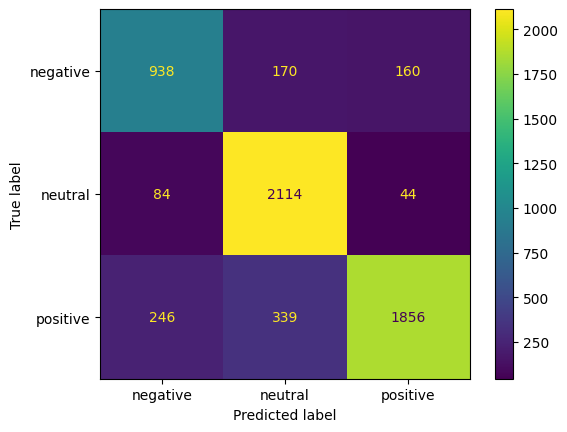

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(lgbm,X_test_processed,
                                      y_test,display_labels=le.classes_)

In [ ]:
# cross validation score
from imblearn.pipeline import Pipeline as Pipe
from sklearn.model_selection import cross_val_score

cross_val_pipe = Pipe([
    ('preprocess',preprocessor),
    #('sampler',adasyn),
    ('lgbm',LGBMClassifier(random_state=42))
])

scores = cross_val_score(cross_val_pipe,X_train,y_train,cv=5,scoring='f1_macro')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.271188 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7601
[LightGBM] [Info] Number of data points in the train set: 19040, number of used features: 2010
[LightGBM] [Info] Start training from score -1.546098
[LightGBM] [Info] Start training from score -0.976079
[LightGBM] [Info] Start training from score -0.891265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.507168 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7824
[LightGBM] [Info] Number of data points in the train set: 19040, number of used features: 2066
[LightGBM] [Info] Start training from score -1.546098
[LightGBM] [Info] Start training from score -0.976079
[LightGBM] [Info] St

In [ ]:
print("The mean score after upsampling and training is ",scores.mean())

The mean score after upsampling and training is  0.794693913355751


### Light GBM + Adasyn(Upsampling)

In [ ]:
# fit the model on data

lgbm = LGBMClassifier(random_state=42)

lgbm.fit(X_train_upsampled,y_train_upsampled)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.843331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35914
[LightGBM] [Info] Number of data points in the train set: 28499, number of used features: 3222
[LightGBM] [Info] Start training from score -1.078775
[LightGBM] [Info] Start training from score -1.147325
[LightGBM] [Info] Start training from score -1.071474


LGBMClassifier(random_state=42)

#### Predictions

In [ ]:
# get the predictions on test data
y_pred_train = lgbm.predict(X_train_upsampled)
y_pred_test = lgbm.predict(X_test_processed)

#### Evaluation

In [ ]:
# print classification report on train data

print(classification_report(y_train_upsampled,y_pred_train))

              precision    recall  f1-score   support

           0       0.94      0.84      0.89      9690
           1       0.81      0.95      0.88      9048
           2       0.89      0.84      0.86      9761

    accuracy                           0.88     28499
   macro avg       0.88      0.88      0.88     28499
weighted avg       0.88      0.88      0.88     28499



In [ ]:
# print the classification report on test data

print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.84      0.65      0.74      1268
           1       0.80      0.95      0.87      2242
           2       0.86      0.81      0.83      2441

    accuracy                           0.83      5951
   macro avg       0.83      0.80      0.81      5951
weighted avg       0.83      0.83      0.82      5951



In [ ]:
# print the accuracy score

print(f'The accuracy score is {accuracy_score(y_test,y_pred_test)}')

The accuracy score is 0.8279280793144009


In [ ]:
# print the f1 score

print(f'The f1 score is {f1_score(y_test,y_pred_test,average="macro")}')

The f1 score is 0.8115975762505117


In [ ]:
le.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

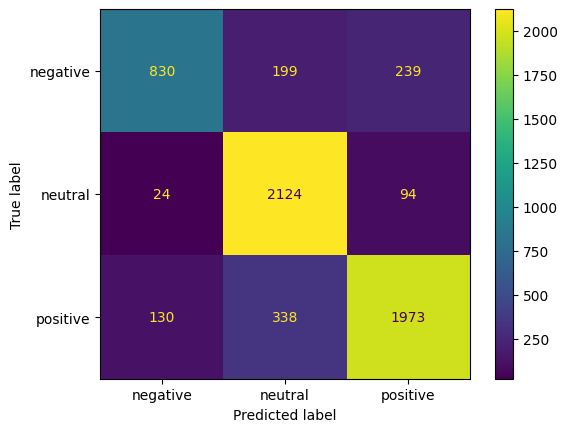

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(lgbm,X_test_processed,
                                      y_test,display_labels=le.classes_)

In [ ]:
# cross validation score
from imblearn.pipeline import Pipeline as Pipe
from sklearn.model_selection import cross_val_score

cross_val_pipe = Pipe([
    ('preprocess',preprocessor),
    ('sampler',adasyn),
    ('lgbm',lgbm)
])

scores = cross_val_score(cross_val_pipe,X_train,y_train,cv=5,scoring='f1_macro')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.502260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27156
[LightGBM] [Info] Number of data points in the train set: 22542, number of used features: 2641
[LightGBM] [Info] Start training from score -1.102212
[LightGBM] [Info] Start training from score -1.134931
[LightGBM] [Info] Start training from score -1.060103
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.668111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 28538
[LightGBM] [Info] Number of data points in the train set: 22861, number of used features: 2687
[LightGBM] [Info] Start training from score -1.073387
[LightGBM] [Info] Start training from score -1.150226
[LightGBM] [Info] 

In [ ]:
print("The mean score after upsampling and training is ",scores.mean())

The mean score after upsampling and training is  0.8007379331392501


### Light GBM + SmoteTomek

In [ ]:
# fit the model on data

lgbm = LGBMClassifier(random_state=42)

lgbm.fit(X_train_combined,y_train_combined)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.969314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36404
[LightGBM] [Info] Number of data points in the train set: 29189, number of used features: 3221
[LightGBM] [Info] Start training from score -1.097038
[LightGBM] [Info] Start training from score -1.100018
[LightGBM] [Info] Start training from score -1.098784


LGBMClassifier(random_state=42)

#### Predictions

In [ ]:
# get the predictions on test data
y_pred_train = lgbm.predict(X_train_combined)
y_pred_test = lgbm.predict(X_test_processed)

#### Evaluation

In [ ]:
# print classification report on train data

print(classification_report(y_train_combined,y_pred_train))

              precision    recall  f1-score   support

           0       0.92      0.84      0.88      9745
           1       0.81      0.94      0.87      9716
           2       0.89      0.83      0.86      9728

    accuracy                           0.87     29189
   macro avg       0.88      0.87      0.87     29189
weighted avg       0.88      0.87      0.87     29189



In [ ]:
# print the classification report on test data

print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.85      0.65      0.74      1268
           1       0.80      0.95      0.87      2242
           2       0.86      0.81      0.83      2441

    accuracy                           0.83      5951
   macro avg       0.83      0.80      0.81      5951
weighted avg       0.83      0.83      0.82      5951



In [ ]:
# print the accuracy score

print(f'The accuracy score is {accuracy_score(y_test,y_pred_test)}')

The accuracy score is 0.8277600403293565


In [ ]:
# print the f1 score

print(f'The f1 score is {f1_score(y_test,y_pred_test,average="macro")}')

The f1 score is 0.8115721373771926


In [ ]:
le.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

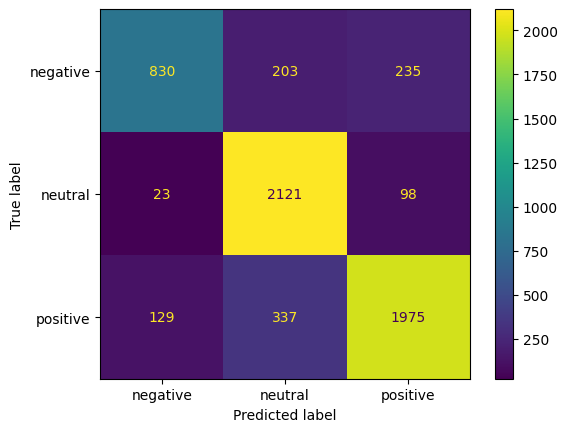

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(lgbm,X_test_processed,
                                      y_test,display_labels=le.classes_)

In [ ]:
# cross validation score
from imblearn.pipeline import Pipeline as Pipe
from sklearn.model_selection import cross_val_score

cross_val_pipe = Pipe([
    ('preprocess',preprocessor),
    ('sampler',smote_tom),
    ('lgbm',LGBMClassifier(random_state=42))
])

scores = cross_val_score(cross_val_pipe,X_train,y_train,cv=5,scoring='f1_macro')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.968313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 28315
[LightGBM] [Info] Number of data points in the train set: 23349, number of used features: 2657
[LightGBM] [Info] Start training from score -1.096815
[LightGBM] [Info] Start training from score -1.099898
[LightGBM] [Info] Start training from score -1.099126
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.012098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 28512
[LightGBM] [Info] Number of data points in the train set: 23333, number of used features: 2700
[LightGBM] [Info] Start training from score -1.096643
[LightGBM] [Info] Start training from score -1.100113
[LightGBM] [Info] 

In [ ]:
print("The mean score after combined sampling and training is ",scores.mean())

The mean score after combined sampling and training is  0.8015579140348228


# Word2Vec(Trained on Dataset)

In [ ]:
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

In [ ]:
# Tokenize the sentences in the 'text' column
final_df['tokenized'] = final_df['comment'].apply(lambda x: word_tokenize(x.lower()))

# Convert the tokenized column into a list of sentences (which are lists of words)
sentences = final_df['tokenized'].tolist()

In [ ]:
final_df.iloc[0,0]

'family mormon never tried explain still stare puzzled time time like kind strange creature nonetheless come admire patience calmness equanimity acceptance compassion developed thing buddhism teach'

In [ ]:
sentences[0]

['family',
 'mormon',
 'never',
 'tried',
 'explain',
 'still',
 'stare',
 'puzzled',
 'time',
 'time',
 'like',
 'kind',
 'strange',
 'creature',
 'nonetheless',
 'come',
 'admire',
 'patience',
 'calmness',
 'equanimity',
 'acceptance',
 'compassion',
 'developed',
 'thing',
 'buddhism',
 'teach']

In [ ]:
# build the model

word_2_vec = Word2Vec(sentences=sentences,
                      vector_size=100,
                      workers=4,
                      min_count=3,
                      window=5,
                      compute_loss=True)

In [ ]:
# build the voacubulary

word_2_vec.build_vocab(sentences)

In [ ]:
word_2_vec.epochs

5

In [ ]:
# train the model

word_2_vec.train(sentences,
                 total_examples=word_2_vec.corpus_count,
                 epochs=15,
                 compute_loss=True)

(6279827, 6942690)

In [ ]:
word_2_vec.corpus_count

29751

In [ ]:
word_2_vec.wv.similarity("india","country")

0.7078697

In [ ]:
word_2_vec.wv.similar_by_word("india")

[('china', 0.7130843997001648),
 ('country', 0.7078697085380554),
 ('russia', 0.6488050818443298),
 ('nation', 0.6445242762565613),
 ('usa', 0.6315973401069641),
 ('canada', 0.6262661218643188),
 ('germany', 0.6232892274856567),
 ('relation', 0.616908073425293),
 ('israel', 0.6030389666557312),
 ('kashmir', 0.5945670008659363)]

In [ ]:
word_2_vec.wv['india']

array([-0.1325575 , -1.0092525 , -0.6981933 ,  1.0317701 , -2.3652928 ,
       -0.80880255,  0.4633932 ,  0.601181  , -2.6911314 , -2.358042  ,
        0.90499914, -1.9683704 , -1.8072178 ,  0.95980716, -0.29634637,
       -0.21375248,  0.7691942 ,  1.008457  , -0.41507885, -0.50851625,
        0.5535739 , -1.3459157 ,  0.53937656, -0.9831779 , -0.49855638,
        0.33727327, -1.3969597 , -2.302457  , -1.6176648 , -0.02072778,
        0.399673  , -0.82705796, -0.20739268,  1.7568833 , -1.2443281 ,
       -0.23363641,  0.64489794,  0.36220688, -0.26984072,  0.32446283,
        0.8840687 , -0.622766  , -0.85375834,  0.95049274, -0.12580495,
        0.82210374,  0.15234153, -0.8366391 ,  0.8727834 , -1.5743937 ,
        0.31366035,  0.31379062,  0.4896551 ,  1.1291531 ,  0.74135196,
        1.4103978 , -0.3373826 ,  0.69037557, -0.7161775 , -0.99842334,
        0.35754803,  1.5535084 , -1.2895622 , -0.8520405 , -1.6281422 ,
        0.5448691 , -0.6865632 ,  0.0877468 ,  1.0111175 ,  0.90

## Prepare Embeddings DataFrame

In [ ]:
def sentence_to_vector(sentence, model):
    word_vectors = [model.wv[word] for word in sentence if word in model.wv]

    # If the sentence contains words that are in the model's vocabulary, compute the average
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

In [ ]:
final_df['embedding'] = final_df['tokenized'].apply(lambda x: sentence_to_vector(x, word_2_vec))


In [ ]:
final_df['embedding'][0].shape

(100,)

In [ ]:
X_embeddings = pd.DataFrame(final_df['embedding'].tolist(),columns=[f"f{i}" for i in range(100)])

X_embeddings

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99
0,-0.270226,0.467907,-0.182532,0.129553,0.363465,-0.681065,0.265712,1.415083,-0.307986,-0.541456,...,0.240033,0.028133,0.085910,0.492835,0.982694,0.176927,0.554534,-0.741742,0.360623,0.699559
1,-0.101448,0.406225,-0.249064,0.142449,0.291029,-0.425697,0.196144,1.085669,-0.252725,-0.474239,...,0.242695,0.276299,-0.029693,0.648852,1.045685,0.320724,0.086285,-0.788319,0.604088,0.188223
2,0.384574,0.315650,-0.311299,0.250343,0.039070,-0.445916,0.307953,0.892465,-0.572662,-0.276928,...,0.065508,0.105761,-0.026319,0.316459,1.175926,0.062285,0.438319,-0.416772,0.500493,0.596648
3,-0.231241,0.391248,-0.061886,0.273890,0.381378,-0.751764,0.103622,1.478924,-0.265821,-0.442407,...,-0.042842,0.001457,0.103923,0.905327,1.046695,0.377435,0.599437,-0.625500,0.765200,0.275266
4,-0.195480,0.224861,-0.152319,0.284297,0.392053,-0.486098,0.114435,0.932150,-0.442893,-0.239252,...,0.113332,0.274215,0.087046,0.648765,1.327983,0.230973,0.432861,-0.708407,0.620462,0.196205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29746,-0.408292,0.542718,-0.483525,-0.330667,-0.315592,-0.016712,-0.184189,1.076272,-0.207499,-0.448234,...,-0.110601,0.517204,-0.726943,0.058150,-0.034375,0.386723,0.491318,-0.103579,0.272171,0.217994
29747,0.062252,-0.133927,0.089296,-0.012215,-0.486864,-0.064083,-0.171858,0.435571,-0.679336,-0.927897,...,0.355121,0.361753,0.275381,0.802860,0.940075,0.939506,-0.210137,-0.563575,-0.186571,0.285783
29748,-1.900287,0.879490,0.219090,-0.577904,0.836370,-0.298124,-0.312480,1.078565,-0.457465,-0.727598,...,0.337387,0.249567,0.016031,0.695904,1.000573,0.035376,-0.765610,-1.026071,-0.379765,-0.441919
29749,-0.469308,0.386075,0.998181,-0.339964,-0.802299,-0.153729,-0.679091,0.475041,-0.025475,0.067629,...,0.730533,0.125172,-0.190290,-0.377469,-0.984357,0.139963,0.537697,-0.663572,0.076982,-0.388332


In [ ]:
# shape of X embeddings
X_embeddings.shape

(29751, 100)

In [ ]:
X_embed = X_embeddings.set_index(final_df.index,drop=False)

In [ ]:
embeddings_df = X_embed.join(final_df.drop(columns=['comment','tokenized','embedding','sentiment']))

In [ ]:
# check for missing values

embeddings_df.isna().sum().sum()

0

In [ ]:
embeddings_df.shape

(29751, 109)

## Feature Engineering

### Scaling

In [ ]:
# scaling columns

cols_to_scale = ['word_count','stop_words_count','nouns','adjectives','verbs',"neg_stop_words_count"]

scaler = RobustScaler()

scaler.set_output(transform='pandas')

scaler.fit_transform(embeddings_df[cols_to_scale])

,word_count,stop_words_count,nouns,adjectives,verbs,neg_stop_words_count
0,1.473684,1.285714,2.000000,0.333333,1.000000,0.0
1,9.736842,7.857143,9.000000,7.666667,9.666667,3.0
2,3.947368,5.142857,2.333333,3.000000,2.000000,0.0
3,0.947368,1.571429,0.500000,0.333333,1.000000,1.0
4,5.315789,5.857143,2.666667,3.666667,6.000000,1.0
...,...,...,...,...,...,...
37242,0.000000,-0.142857,0.666667,-0.333333,-0.333333,0.0
37243,0.578947,0.285714,0.500000,0.333333,1.333333,0.0
37244,-0.526316,-0.571429,-0.500000,-0.333333,-0.333333,0.0
37246,-0.263158,-0.571429,0.000000,0.000000,-0.333333,0.0


### Encoding

In [ ]:
# categories in sentence length

embeddings_df['sentence_length'].unique()

['Long', 'Very Long', 'Medium', 'Short']
Categories (4, object): ['Short' < 'Medium' < 'Long' < 'Very Long']

In [ ]:
ord_encoder = OrdinalEncoder(categories=[['Short','Medium','Long','Very Long']])
ord_encoder.set_output(transform='pandas')
ord_encoder.fit_transform(embeddings_df[['sentence_length']])

ord_encoder.categories_

[array(['Short', 'Medium', 'Long', 'Very Long'], dtype=object)]

In [ ]:
# count encoding

count_enc = CountFrequencyEncoder(encoding_method='frequency')
count_enc.set_output(transform='pandas')
count_enc.fit_transform(embeddings_df[['sentence_length']])

,sentence_length
0,0.132869
1,0.108702
2,0.108702
3,0.132869
4,0.108702
...,...
37242,0.292024
37243,0.292024
37244,0.466404
37246,0.466404


In [ ]:
sentence_union = FeatureUnion([
    ('count_enc',count_enc),
    ('ord_encoder',ord_encoder)
])

sentence_union.set_output(transform='pandas')

sentence_union.fit_transform(embeddings_df[['sentence_length']])

,count_enc__sentence_length,ord_encoder__sentence_length
0,0.132869,2.0
1,0.108702,3.0
2,0.108702,3.0
3,0.132869,2.0
4,0.108702,3.0
...,...,...
37242,0.292024,1.0
37243,0.292024,1.0
37244,0.466404,0.0
37246,0.466404,0.0


In [ ]:
# pipeline of sentence length column

sentence_pipe = Pipeline([
    ('sentence_union',sentence_union),
    ('scale',MinMaxScaler())
])

sentence_pipe.set_output(transform='pandas')

sentence_pipe.fit_transform(embeddings_df[['sentence_length']])

,count_enc__sentence_length,ord_encoder__sentence_length
0,0.067562,0.666667
1,0.000000,1.000000
2,0.000000,1.000000
3,0.067562,0.666667
4,0.000000,1.000000
...,...,...
37242,0.512498,0.333333
37243,0.512498,0.333333
37244,1.000000,0.000000
37246,1.000000,0.000000


In [ ]:
# make X and y

X = embeddings_df.drop(columns=['named_sentiment'])
y = embeddings_df['named_sentiment']

In [ ]:
X

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f98,f99,stop_words_count,neg_stop_words_count,word_count,sentence_length,response,nouns,verbs,adjectives
0,-0.270226,0.467907,-0.182532,0.129553,0.363465,-0.681065,0.265712,1.415083,-0.307986,-0.541456,...,0.360623,0.699559,13,0,39,Long,0,16,4,2
1,-0.101448,0.406225,-0.249064,0.142449,0.291029,-0.425697,0.196144,1.085669,-0.252725,-0.474239,...,0.604088,0.188223,59,3,196,Very Long,0,58,30,24
2,0.384574,0.315650,-0.311299,0.250343,0.039070,-0.445916,0.307953,0.892465,-0.572662,-0.276928,...,0.500493,0.596648,40,0,86,Very Long,0,18,7,10
3,-0.231241,0.391248,-0.061886,0.273890,0.381378,-0.751764,0.103622,1.478924,-0.265821,-0.442407,...,0.765200,0.275266,15,1,29,Long,0,7,4,2
4,-0.195480,0.224861,-0.152319,0.284297,0.392053,-0.486098,0.114435,0.932150,-0.442893,-0.239252,...,0.620462,0.196205,45,1,112,Very Long,0,20,19,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37242,-0.408292,0.542718,-0.483525,-0.330667,-0.315592,-0.016712,-0.184189,1.076272,-0.207499,-0.448234,...,0.272171,0.217994,3,0,11,Medium,0,8,0,0
37243,0.062252,-0.133927,0.089296,-0.012215,-0.486864,-0.064083,-0.171858,0.435571,-0.679336,-0.927897,...,-0.186571,0.285783,6,0,22,Medium,0,7,5,2
37244,-1.900287,0.879490,0.219090,-0.577904,0.836370,-0.298124,-0.312480,1.078565,-0.457465,-0.727598,...,-0.379765,-0.441919,0,0,1,Short,1,1,0,0
37246,-0.469308,0.386075,0.998181,-0.339964,-0.802299,-0.153729,-0.679091,0.475041,-0.025475,0.067629,...,0.076982,-0.388332,0,0,6,Short,0,4,0,1


In [ ]:
y

,named_sentiment
0,positive
1,positive
2,negative
3,neutral
4,positive
...,...
37242,neutral
37243,negative
37244,neutral
37246,neutral


In [ ]:
# train test split with test size 0.2

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,
                                                    random_state=42,stratify=y)

X_train

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f98,f99,stop_words_count,neg_stop_words_count,word_count,sentence_length,response,nouns,verbs,adjectives
23054,-0.950073,0.573669,1.001948,-0.898306,-1.163175,0.003024,-1.093600,0.901742,-0.251943,-0.485315,...,-0.181688,-0.290271,0,0,5,Short,0,5,0,0
33846,-0.087731,0.466641,-0.578597,0.356299,0.435354,-0.271478,0.131337,0.587634,-0.476150,0.452853,...,0.098611,-0.020293,7,0,17,Medium,0,4,3,1
22590,-0.126014,0.051041,-0.253940,0.388312,-0.144331,-0.084854,0.036395,0.855906,-0.536223,-0.976105,...,0.274070,0.257979,17,2,40,Long,0,12,2,7
223,0.184825,0.212258,0.011939,-0.050124,-0.145406,-0.250070,-0.023107,0.344250,-0.355097,-0.075801,...,0.023320,0.020044,3,0,7,Short,0,1,1,1
16425,0.344713,0.036092,-0.244829,-0.146675,-0.169404,-0.145099,0.401922,0.308091,-0.059486,0.056514,...,-0.360844,-0.139611,1,0,3,Short,1,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5033,0.186230,0.237290,-0.339973,0.169061,0.088993,-0.317953,0.061175,0.977353,-0.342463,-0.477381,...,0.545815,0.401986,22,1,60,Very Long,0,16,8,4
31749,0.299751,0.179165,-0.009370,0.274614,-0.406679,-0.275023,0.162770,0.701104,-0.703502,-0.466456,...,0.312077,0.230345,12,0,30,Long,0,8,2,6
31306,0.309869,0.329113,-0.616848,0.224362,0.411710,-0.367412,0.161831,0.822419,-0.198221,-0.637464,...,0.626275,0.334322,23,0,69,Very Long,0,17,9,11
27772,-0.078215,0.245895,-0.156214,0.145036,0.244541,-0.351308,-0.191881,0.508146,-0.295570,-0.107614,...,0.342449,0.203661,32,0,74,Very Long,0,16,8,13


In [ ]:
# shapes of X_train and X_test

print(f'The shape of X_train is {X_train.shape}')
print(f'The shape of X_test is {X_test.shape}')

The shape of X_train is (23800, 108)
The shape of X_test is (5951, 108)


In [ ]:
# class distributions of y_train and y_test

print(y_train.value_counts(normalize=True))
print("*" * 30)
print(y_test.value_counts(normalize=True))

named_sentiment
positive    0.410126
neutral     0.376807
negative    0.213067
Name: proportion, dtype: float64
******************************
named_sentiment
positive    0.410183
neutral     0.376743
negative    0.213073
Name: proportion, dtype: float64


In [ ]:
# label encode y_train and y_test

le = LabelEncoder()

le.fit(y_train)

y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [ ]:
le.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

In [ ]:
# preprocessor

preprocessor = ColumnTransformer([
    ('scale',scaler,cols_to_scale),
    ('sentence_pipe',sentence_pipe,['sentence_length'])
],remainder='passthrough',n_jobs=-1)

preprocessor

ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('scale', RobustScaler(),
                                 ['word_count', 'stop_words_count', 'nouns',
                                  'adjectives', 'verbs',
                                  'neg_stop_words_count']),
                                ('sentence_pipe',
                                 Pipeline(steps=[('sentence_union',
                                                  FeatureUnion(transformer_list=[('count_enc',
                                                                                  CountFrequencyEncoder(encoding_method='frequency')),
                                                                                 ('ord_encoder',
                                                                                  OrdinalEncoder(categories=[['Short',
                                                                                                              'Medium',
                                                                                                              'Long',
                                                                                                              'Very '
                                                                                                              'Long']]))])),
                                                 ('scale', MinMaxScaler())]),
                                 ['sentence_length'])])

In [ ]:
# preprocess the data

X_train_processed = preprocessor.fit_transform(X_train)

X_test_processed = preprocessor.transform(X_test)

In [ ]:
X_train_processed.shape

(23800, 109)

### Light GBM

In [ ]:
# fit the model on data

lgbm = LGBMClassifier(random_state=42,class_weight=class_weights_dict)

lgbm.fit(X_train_processed,y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26149
[LightGBM] [Info] Number of data points in the train set: 23800, number of used features: 109
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


LGBMClassifier(class_weight={0: 1.564451455991586, 1: 0.8846268212905144,
                             2: 0.8127582556432059},
               random_state=42)

#### Predictions

In [ ]:
# get the predictions on test data
y_pred_train = lgbm.predict(X_train_processed)
y_pred_test = lgbm.predict(X_test_processed)

#### Evaluation

In [ ]:
# print classification report on train data

print(classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

           0       0.70      0.85      0.77      5071
           1       0.87      0.89      0.88      8968
           2       0.90      0.78      0.84      9761

    accuracy                           0.84     23800
   macro avg       0.82      0.84      0.83     23800
weighted avg       0.85      0.84      0.84     23800



In [ ]:
# print the classification report on test data

print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.47      0.55      0.51      1268
           1       0.76      0.78      0.77      2242
           2       0.73      0.65      0.69      2441

    accuracy                           0.68      5951
   macro avg       0.65      0.66      0.66      5951
weighted avg       0.69      0.68      0.68      5951



In [ ]:
# print the accuracy score

print(f'The accuracy score is {accuracy_score(y_test,y_pred_test)}')

The accuracy score is 0.6778692656696353


In [ ]:
# print the f1 score

print(f'The f1 score is {f1_score(y_test,y_pred_test,average="macro")}')

The f1 score is 0.6551259202121962


In [ ]:
le.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

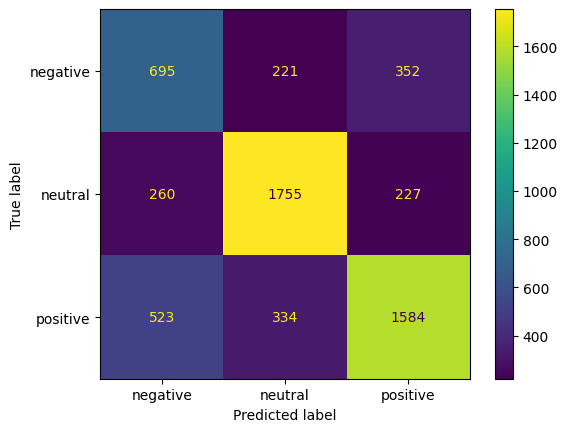

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(lgbm,X_test_processed,
                                      y_test,display_labels=le.classes_)

In [ ]:
# cross validation score
from imblearn.pipeline import Pipeline as Pipe
from sklearn.model_selection import cross_val_score

cross_val_pipe = Pipe([
    ('preprocess',preprocessor),
    ('lgbm',lgbm)
])

scores = cross_val_score(cross_val_pipe,X_train,y_train,cv=5,scoring='f1_macro')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26113
[LightGBM] [Info] Number of data points in the train set: 19040, number of used features: 109
[LightGBM] [Info] Start training from score -1.098569
[LightGBM] [Info] Start training from score -1.098674
[LightGBM] [Info] Start training from score -1.098593
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26131
[LightGBM] [Info] Number of data points in the train set: 19040, number of used features: 109
[LightGBM] [Info] Start training from score -1.098569
[LightGBM] [Info] Start training from score -1.098674
[LightGBM] [Info] Start training from score -1.098593
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045674

In [ ]:
print("The mean score after upsampling and training is ",scores.mean())

The mean score after upsampling and training is  0.6563020650019804


# Word2Vec(Pretrained)

In [ ]:
from gensim.models import Word2Vec, KeyedVectors
from gensim.utils import simple_preprocess

In [ ]:
import gensim.downloader

In [ ]:
google_news = gensim.downloader.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
# Tokenize the sentences in the 'text' column
final_df['tokenized'] = final_df['comment'].apply(lambda x: word_tokenize(x.lower()))

# Convert the tokenized column into a list of sentences (which are lists of words)
sentences = final_df['tokenized'].tolist()

In [ ]:
final_df.iloc[0,0]

'family mormon never tried explain still stare puzzled time time like kind strange creature nonetheless come admire patience calmness equanimity acceptance compassion developed thing buddhism teach'

In [ ]:
sentences[0]

['family',
 'mormon',
 'never',
 'tried',
 'explain',
 'still',
 'stare',
 'puzzled',
 'time',
 'time',
 'like',
 'kind',
 'strange',
 'creature',
 'nonetheless',
 'come',
 'admire',
 'patience',
 'calmness',
 'equanimity',
 'acceptance',
 'compassion',
 'developed',
 'thing',
 'buddhism',
 'teach']

In [ ]:
# build the model

word_2_vec = google_news

In [ ]:
word_2_vec.similarity("india","country")

0.21845311

In [ ]:
word_2_vec.similar_by_word("india")

[('indian', 0.6967039704322815),
 ('usa', 0.6836211085319519),
 ('pakistan', 0.681516706943512),
 ('chennai', 0.6675503253936768),
 ('america', 0.6589399576187134),
 ('sri_lanka', 0.64982008934021),
 ('canada', 0.6490967869758606),
 ('australia', 0.6368584036827087),
 ('mexico', 0.6239137649536133),
 ('uk', 0.6221641898155212)]

In [ ]:
word_2_vec['india']

array([-2.34375000e-01, -7.17773438e-02,  1.05590820e-02,  3.26171875e-01,
       -6.29882812e-02, -1.78710938e-01,  3.17382812e-02, -3.96484375e-01,
       -1.69921875e-01, -3.54003906e-02, -1.81640625e-01, -3.28125000e-01,
        6.59179688e-02, -2.07031250e-01,  1.19140625e-01,  1.74804688e-01,
       -1.10839844e-01,  3.30078125e-01,  5.20019531e-02, -2.47802734e-02,
        1.48773193e-03, -1.60156250e-01,  2.70996094e-02, -1.80664062e-01,
       -4.14062500e-01,  1.95312500e-01, -3.49609375e-01,  1.03515625e-01,
       -8.54492188e-02, -1.48437500e-01, -8.25195312e-02, -2.90527344e-02,
       -3.02734375e-01,  1.98974609e-02, -3.26171875e-01,  1.70898438e-01,
       -4.55078125e-01, -4.39453125e-03,  4.27734375e-01, -2.13867188e-01,
       -6.86645508e-03,  1.23535156e-01,  4.96093750e-01,  3.41796875e-01,
        1.70898438e-01, -1.56250000e-01, -9.42382812e-02, -5.73730469e-02,
       -1.95312500e-01,  6.44531250e-02, -1.49414062e-01,  1.58203125e-01,
        2.53906250e-01,  

## Prepare Embeddings DataFrame

In [ ]:
def sentence_to_vector(sentence, model):
    word_vectors = [model[word] for word in sentence if word in model]

    # If the sentence contains words that are in the model's vocabulary, compute the average
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

In [ ]:
final_df['embedding'] = final_df['tokenized'].apply(lambda x: sentence_to_vector(x, word_2_vec))


In [ ]:
final_df['embedding'][0].shape

(300,)

In [ ]:
X_embeddings = pd.DataFrame(final_df['embedding'].tolist(),columns=[f"f{i}" for i in range(300)])

X_embeddings

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f290,f291,f292,f293,f294,f295,f296,f297,f298,f299
0,0.111042,0.054631,0.046925,0.145905,-0.085439,0.036157,0.118838,-0.066235,0.069925,0.065796,...,-0.107203,0.055137,-0.093502,-0.048664,-0.102655,-0.015996,0.044081,-0.016006,-0.018393,0.049800
1,0.099148,0.022433,0.035707,0.118988,-0.054757,0.049240,0.092836,-0.082056,0.076693,0.081173,...,-0.076558,0.049143,-0.086794,0.008500,-0.061887,-0.012597,0.000045,-0.109387,0.014394,0.014926
2,0.049455,0.014697,0.021067,0.107072,-0.067122,0.014076,0.098926,-0.073242,0.096101,0.035903,...,-0.051713,0.092658,-0.074368,0.016703,-0.050762,-0.023967,0.029028,-0.064589,0.034992,0.003659
3,0.105336,0.094169,0.039948,0.101702,-0.054923,0.009648,0.096976,-0.067365,0.039910,-0.003603,...,-0.083819,0.017194,-0.060804,-0.001064,-0.056213,-0.061087,0.029892,-0.065761,0.020006,-0.006269
4,0.031955,0.011084,0.016148,0.133840,-0.109914,0.038881,0.104046,-0.040371,0.086029,0.068179,...,-0.077152,0.045924,-0.043821,0.046813,-0.038456,0.042072,-0.010655,-0.059630,0.020042,-0.016980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29746,-0.010254,0.021354,0.021641,0.187465,0.059937,0.012259,0.194955,-0.092058,0.154550,0.055123,...,-0.135672,0.094622,0.000897,-0.038592,-0.038749,0.100420,-0.076791,-0.015459,0.109541,0.070862
29747,-0.063216,0.024178,0.102380,0.125045,-0.086800,-0.026396,0.042676,-0.091064,0.009622,0.085197,...,-0.068663,0.102181,-0.057821,0.015503,-0.078352,-0.027441,-0.052421,-0.062722,-0.010595,-0.007137
29748,-0.056396,0.173828,0.012634,0.539062,-0.095703,0.223633,-0.071289,-0.225586,0.003723,-0.150391,...,0.014587,0.040771,-0.166992,-0.183594,-0.190430,-0.119141,0.050781,-0.421875,-0.090332,0.140625
29749,-0.091309,0.039958,0.250732,0.072103,0.011068,-0.009440,0.069336,-0.083354,0.048767,0.233236,...,0.120702,0.198242,-0.017883,0.095052,-0.063477,0.046916,-0.003235,-0.075928,-0.056559,0.253581


In [ ]:
# shape of X embeddings
X_embeddings.shape

(29751, 300)

In [ ]:
X_embed = X_embeddings.set_index(final_df.index,drop=False)

In [ ]:
embeddings_df = X_embed.join(final_df.drop(columns=['comment','tokenized','embedding','sentiment']))

In [ ]:
# check for missing values

embeddings_df.isna().sum().sum()

0

In [ ]:
embeddings_df.shape

(29751, 309)

## Feature Engineering

### Scaling

In [ ]:
# scaling columns

cols_to_scale = ['word_count','stop_words_count','nouns','adjectives','verbs',"neg_stop_words_count"]

scaler = RobustScaler()

scaler.set_output(transform='pandas')

scaler.fit_transform(embeddings_df[cols_to_scale])

,word_count,stop_words_count,nouns,adjectives,verbs,neg_stop_words_count
0,1.473684,1.285714,2.000000,0.333333,1.000000,0.0
1,9.736842,7.857143,9.000000,7.666667,9.666667,3.0
2,3.947368,5.142857,2.333333,3.000000,2.000000,0.0
3,0.947368,1.571429,0.500000,0.333333,1.000000,1.0
4,5.315789,5.857143,2.666667,3.666667,6.000000,1.0
...,...,...,...,...,...,...
37242,0.000000,-0.142857,0.666667,-0.333333,-0.333333,0.0
37243,0.578947,0.285714,0.500000,0.333333,1.333333,0.0
37244,-0.526316,-0.571429,-0.500000,-0.333333,-0.333333,0.0
37246,-0.263158,-0.571429,0.000000,0.000000,-0.333333,0.0


### Encoding

In [ ]:
# categories in sentence length

embeddings_df['sentence_length'].unique()

['Long', 'Very Long', 'Medium', 'Short']
Categories (4, object): ['Short' < 'Medium' < 'Long' < 'Very Long']

In [ ]:
ord_encoder = OrdinalEncoder(categories=[['Short','Medium','Long','Very Long']])
ord_encoder.set_output(transform='pandas')
ord_encoder.fit_transform(embeddings_df[['sentence_length']])

ord_encoder.categories_

[array(['Short', 'Medium', 'Long', 'Very Long'], dtype=object)]

In [ ]:
# count encoding

count_enc = CountFrequencyEncoder(encoding_method='frequency')
count_enc.set_output(transform='pandas')
count_enc.fit_transform(embeddings_df[['sentence_length']])

,sentence_length
0,0.132869
1,0.108702
2,0.108702
3,0.132869
4,0.108702
...,...
37242,0.292024
37243,0.292024
37244,0.466404
37246,0.466404


In [ ]:
sentence_union = FeatureUnion([
    ('count_enc',count_enc),
    ('ord_encoder',ord_encoder)
])

sentence_union.set_output(transform='pandas')

sentence_union.fit_transform(embeddings_df[['sentence_length']])

,count_enc__sentence_length,ord_encoder__sentence_length
0,0.132869,2.0
1,0.108702,3.0
2,0.108702,3.0
3,0.132869,2.0
4,0.108702,3.0
...,...,...
37242,0.292024,1.0
37243,0.292024,1.0
37244,0.466404,0.0
37246,0.466404,0.0


In [ ]:
# pipeline of sentence length column

sentence_pipe = Pipeline([
    ('sentence_union',sentence_union),
    ('scale',MinMaxScaler())
])

sentence_pipe.set_output(transform='pandas')

sentence_pipe.fit_transform(embeddings_df[['sentence_length']])

,count_enc__sentence_length,ord_encoder__sentence_length
0,0.067562,0.666667
1,0.000000,1.000000
2,0.000000,1.000000
3,0.067562,0.666667
4,0.000000,1.000000
...,...,...
37242,0.512498,0.333333
37243,0.512498,0.333333
37244,1.000000,0.000000
37246,1.000000,0.000000


In [ ]:
# make X and y

X = embeddings_df.drop(columns=['named_sentiment'])
y = embeddings_df['named_sentiment']

In [ ]:
X

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f298,f299,stop_words_count,neg_stop_words_count,word_count,sentence_length,response,nouns,verbs,adjectives
0,0.111042,0.054631,0.046925,0.145905,-0.085439,0.036157,0.118838,-0.066235,0.069925,0.065796,...,-0.018393,0.049800,13,0,39,Long,0,16,4,2
1,0.099148,0.022433,0.035707,0.118988,-0.054757,0.049240,0.092836,-0.082056,0.076693,0.081173,...,0.014394,0.014926,59,3,196,Very Long,0,58,30,24
2,0.049455,0.014697,0.021067,0.107072,-0.067122,0.014076,0.098926,-0.073242,0.096101,0.035903,...,0.034992,0.003659,40,0,86,Very Long,0,18,7,10
3,0.105336,0.094169,0.039948,0.101702,-0.054923,0.009648,0.096976,-0.067365,0.039910,-0.003603,...,0.020006,-0.006269,15,1,29,Long,0,7,4,2
4,0.031955,0.011084,0.016148,0.133840,-0.109914,0.038881,0.104046,-0.040371,0.086029,0.068179,...,0.020042,-0.016980,45,1,112,Very Long,0,20,19,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37242,-0.010254,0.021354,0.021641,0.187465,0.059937,0.012259,0.194955,-0.092058,0.154550,0.055123,...,0.109541,0.070862,3,0,11,Medium,0,8,0,0
37243,-0.063216,0.024178,0.102380,0.125045,-0.086800,-0.026396,0.042676,-0.091064,0.009622,0.085197,...,-0.010595,-0.007137,6,0,22,Medium,0,7,5,2
37244,-0.056396,0.173828,0.012634,0.539062,-0.095703,0.223633,-0.071289,-0.225586,0.003723,-0.150391,...,-0.090332,0.140625,0,0,1,Short,1,1,0,0
37246,-0.091309,0.039958,0.250732,0.072103,0.011068,-0.009440,0.069336,-0.083354,0.048767,0.233236,...,-0.056559,0.253581,0,0,6,Short,0,4,0,1


In [ ]:
y

,named_sentiment
0,positive
1,positive
2,negative
3,neutral
4,positive
...,...
37242,neutral
37243,negative
37244,neutral
37246,neutral


In [ ]:
# train test split with test size 0.2

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,
                                                    random_state=42,stratify=y)

X_train

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f298,f299,stop_words_count,neg_stop_words_count,word_count,sentence_length,response,nouns,verbs,adjectives
23054,0.048645,0.047546,0.119019,0.276855,-0.077179,0.008118,0.089249,-0.073517,0.038284,0.249207,...,0.069885,0.225342,0,0,5,Short,0,5,0,0
33846,0.071578,0.018322,0.086698,0.163775,-0.035656,-0.024744,0.016990,-0.054710,0.080100,0.132591,...,-0.034823,0.011652,7,0,17,Medium,0,4,3,1
22590,0.066126,-0.009888,0.050507,0.262196,-0.072904,-0.029198,0.085299,0.030171,0.082506,0.014747,...,0.094310,0.001953,17,2,40,Long,0,12,2,7
223,-0.038635,0.176331,0.041016,-0.022705,0.037598,0.098969,0.053528,-0.050964,0.038769,0.125244,...,-0.013855,0.070984,3,0,7,Short,0,1,1,1
16425,0.148438,-0.044434,0.131836,0.225586,-0.048340,0.008301,0.067871,0.059082,0.074219,0.058594,...,-0.128906,0.078613,1,0,3,Short,1,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5033,0.074160,0.006752,0.005080,0.077592,-0.093038,0.040969,0.137674,-0.115503,0.056463,0.005690,...,0.022627,0.013020,22,1,60,Very Long,0,16,8,4
31749,-0.005424,-0.028097,0.029387,0.065453,-0.145491,0.057285,-0.022888,-0.057888,0.125461,0.052260,...,0.006755,-0.008218,12,0,30,Long,0,8,2,6
31306,0.085490,0.013387,0.053133,0.126468,-0.072743,0.010060,0.118635,-0.021801,0.105604,0.061688,...,0.047500,-0.013810,23,0,69,Very Long,0,17,9,11
27772,0.025503,0.007037,-0.022641,0.101313,-0.102536,0.054981,0.077994,-0.038021,0.063076,0.064241,...,0.028129,0.031827,32,0,74,Very Long,0,16,8,13


In [ ]:
# shapes of X_train and X_test

print(f'The shape of X_train is {X_train.shape}')
print(f'The shape of X_test is {X_test.shape}')

The shape of X_train is (23800, 308)
The shape of X_test is (5951, 308)


In [ ]:
# class distributions of y_train and y_test

print(y_train.value_counts(normalize=True))
print("*" * 30)
print(y_test.value_counts(normalize=True))

named_sentiment
positive    0.410126
neutral     0.376807
negative    0.213067
Name: proportion, dtype: float64
******************************
named_sentiment
positive    0.410183
neutral     0.376743
negative    0.213073
Name: proportion, dtype: float64


In [ ]:
# label encode y_train and y_test

le = LabelEncoder()

le.fit(y_train)

y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [ ]:
le.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

In [ ]:
# preprocessor

preprocessor = ColumnTransformer([
    ('scale',scaler,cols_to_scale),
    ('sentence_pipe',sentence_pipe,['sentence_length'])
],remainder='passthrough',n_jobs=-1)

preprocessor

ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('scale', RobustScaler(),
                                 ['word_count', 'stop_words_count', 'nouns',
                                  'adjectives', 'verbs',
                                  'neg_stop_words_count']),
                                ('sentence_pipe',
                                 Pipeline(steps=[('sentence_union',
                                                  FeatureUnion(transformer_list=[('count_enc',
                                                                                  CountFrequencyEncoder(encoding_method='frequency')),
                                                                                 ('ord_encoder',
                                                                                  OrdinalEncoder(categories=[['Short',
                                                                                                              'Medium',
                                                                                                              'Long',
                                                                                                              'Very '
                                                                                                              'Long']]))])),
                                                 ('scale', MinMaxScaler())]),
                                 ['sentence_length'])])

In [ ]:
# preprocess the data

X_train_processed = preprocessor.fit_transform(X_train)

X_test_processed = preprocessor.transform(X_test)

In [ ]:
X_train_processed.shape

(23800, 309)

### Light GBM

In [ ]:
# fit the model on data

lgbm = LGBMClassifier(random_state=42,class_weight=class_weights_dict)

lgbm.fit(X_train_processed,y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.164998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 77149
[LightGBM] [Info] Number of data points in the train set: 23800, number of used features: 309
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


LGBMClassifier(class_weight={0: 1.564451455991586, 1: 0.8846268212905144,
                             2: 0.8127582556432059},
               random_state=42)

#### Predictions

In [ ]:
# get the predictions on test data
y_pred_train = lgbm.predict(X_train_processed)
y_pred_test = lgbm.predict(X_test_processed)

#### Evaluation

In [ ]:
# print classification report on train data

print(classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

           0       0.81      0.93      0.87      5071
           1       0.91      0.92      0.92      8968
           2       0.93      0.86      0.89      9761

    accuracy                           0.90     23800
   macro avg       0.89      0.90      0.89     23800
weighted avg       0.90      0.90      0.90     23800



In [ ]:
# print the classification report on test data

print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.55      0.60      0.57      1268
           1       0.78      0.80      0.79      2242
           2       0.75      0.70      0.72      2441

    accuracy                           0.72      5951
   macro avg       0.69      0.70      0.70      5951
weighted avg       0.72      0.72      0.72      5951



In [ ]:
# print the accuracy score

print(f'The accuracy score is {accuracy_score(y_test,y_pred_test)}')

The accuracy score is 0.7156780373046547


In [ ]:
# print the f1 score

print(f'The f1 score is {f1_score(y_test,y_pred_test,average="macro")}')

The f1 score is 0.6954261101962368


In [ ]:
le.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

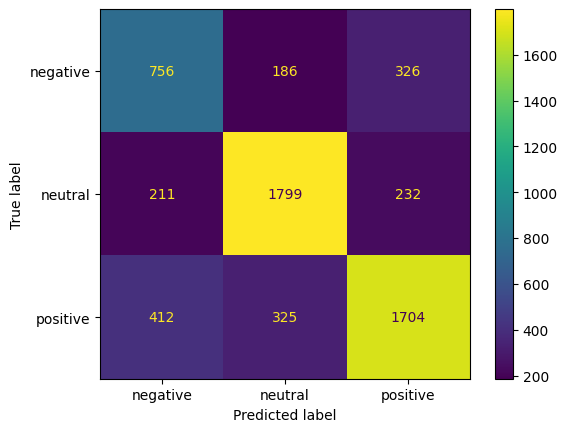

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(lgbm,X_test_processed,
                                      y_test,display_labels=le.classes_)

In [ ]:
# cross validation score
from imblearn.pipeline import Pipeline as Pipe
from sklearn.model_selection import cross_val_score

cross_val_pipe = Pipe([
    ('preprocess',preprocessor),
    ('lgbm',lgbm)
])

scores = cross_val_score(cross_val_pipe,X_train,y_train,cv=5,scoring='f1_macro')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.175023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 77113
[LightGBM] [Info] Number of data points in the train set: 19040, number of used features: 309
[LightGBM] [Info] Start training from score -1.098569
[LightGBM] [Info] Start training from score -1.098674
[LightGBM] [Info] Start training from score -1.098593
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.137289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 77131
[LightGBM] [Info] Number of data points in the train set: 19040, number of used features: 309
[LightGBM] [Info] Start training from score -1.098569
[LightGBM] [Info] Start training from score -1.098674
[LightGBM] [Info] Start training from score -1.098593
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.173284

In [ ]:
print("The mean score after upsampling and training is ",scores.mean())

The mean score after upsampling and training is  0.6948719343615106
